In [1]:
import bisect
import pandas as pd
import numpy as np
%pylab inline
import seaborn as sns
sns.set_style('darkgrid')
from scipy.stats import mstats
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_curve
from sklearn.preprocessing import LabelEncoder

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [8]:
# open data
df = pd.read_csv('telco.csv')

In [9]:
df.describe()

,account length,area code,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
count,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333
mean,101.064806,437.182418,8.099010,179.775098,100.435644,30.562307,200.980348,100.114311,17.083540,200.872037,100.107711,9.039325,10.237294,4.479448,2.764581,1.562856,0.144914
std,39.822106,42.371290,13.688365,54.467389,20.069084,9.259435,50.713844,19.922625,4.310668,50.573847,19.568609,2.275873,2.791840,2.461214,0.753773,1.315491,0.352067
min,1.000000,408.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,23.200000,33.000000,1.040000,0.000000,0.000000,0.000000,0.000000,False
25%,74.000000,408.000000,0.000000,143.700000,87.000000,24.430000,166.600000,87.000000,14.160000,167.000000,87.000000,7.520000,8.500000,3.000000,2.300000,1.000000,0
50%,101.000000,415.000000,0.000000,179.400000,101.000000,30.500000,201.400000,100.000000,17.120000,201.200000,100.000000,9.050000,10.300000,4.000000,2.780000,1.000000,0
75%,127.000000,510.000000,20.000000,216.400000,114.000000,36.790000,235.300000,114.000000,20.000000,235.300000,113.000000,10.590000,12.100000,6.000000,3.270000,2.000000,0
max,243.000000,510.000000,51.000000,350.800000,165.000000,59.640000,363.700000,170.000000,30.910000,395.000000,175.000000,17.770000,20.000000,20.000000,5.400000,9.000000,True


In [10]:
df.columns

Index([u'state', u'account length', u'area code', u'phone number',
       u'international plan', u'voice mail plan', u'number vmail messages',
       u'total day minutes', u'total day calls', u'total day charge',
       u'total eve minutes', u'total eve calls', u'total eve charge',
       u'total night minutes', u'total night calls', u'total night charge',
       u'total intl minutes', u'total intl calls', u'total intl charge',
       u'customer service calls', u'churn'],
      dtype='object')

In [11]:
# clean-up column names
df.columns = [c.lower().replace(' ', '_').replace('?', '').replace("'", "") for c in df.columns]

# remove phone number
del df['phone_number']

# one hot encode state and binaries
state_encoder = LabelEncoder()
df.state = state_encoder.fit_transform(df.state)
binary_columns = ['international_plan', 'voice_mail_plan']  
for col in binary_columns:  
    df[col] = df[col].map({
            'no': 0,
            'False': 0,
            'yes': 1,
            'True': 1
    })
df.head()

,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,customer_service_calls,churn
0,16,128,415,0,1,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,35,107,415,0,1,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,31,137,415,0,0,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,35,84,408,1,0,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,36,75,415,1,0,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


In [12]:
# build random forest
clf = RandomForestClassifier(n_estimators=50, oob_score=True)  
n_trials = 100
test_size_percent = 0.1

# build labels
signals = df[[c for c in df.columns if c != 'churn']]  
labels = df['churn']

# test train split
plot_data = []
for trial in range(n_trials):
    train_signals, test_signals, train_labels, test_labels = train_test_split(
                                                            signals, labels, test_size=test_size_percent)
    clf.fit(train_signals, train_labels)
    predictions = clf.predict_proba(test_signals)[:,1]
    precision, recall, thresholds = precision_recall_curve(test_labels, predictions)  
    thresholds = np.append(thresholds, 1)
    queue_rate = []  
    for threshold in thresholds:  
        queue_rate.append((predictions >= threshold).mean())
        
    # save plot data
    plot_data.append({
            'thresholds': thresholds
        ,   'precision': precision
        ,   'recall': recall
        ,   'queue_rate': queue_rate
    })

/usr/local/lib/python2.7/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


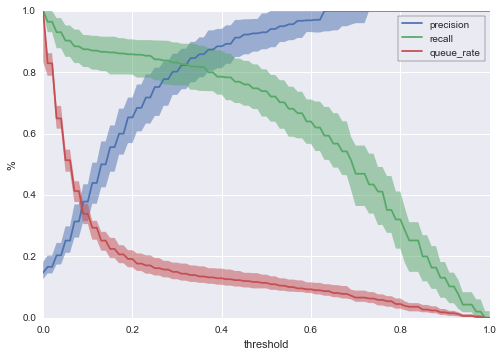

In [13]:
# plot model
uniform_thresholds = np.linspace(0, 1, 101)
uniform_precision_plots = []  
uniform_recall_plots= []  
uniform_queue_rate_plots= []
for p in plot_data:  
    uniform_precision = []
    uniform_recall = []
    uniform_queue_rate = []
    for ut in uniform_thresholds:
        index = bisect.bisect_left(p['thresholds'], ut)
        uniform_precision.append(p['precision'][index])
        uniform_recall.append(p['recall'][index])
        uniform_queue_rate.append(p['queue_rate'][index])

    uniform_precision_plots.append(uniform_precision)
    uniform_recall_plots.append(uniform_recall)
    uniform_queue_rate_plots.append(uniform_queue_rate)

quantiles = [0.1, 0.5, 0.9]  
lower_precision, median_precision, upper_precision = mstats.mquantiles(uniform_precision_plots, quantiles, axis=0)  
lower_recall, median_recall, upper_recall = mstats.mquantiles(uniform_recall_plots, quantiles, axis=0)  
lower_queue_rate, median_queue_rate, upper_queue_rate = mstats.mquantiles(uniform_queue_rate_plots, quantiles, axis=0)

plt.plot(uniform_thresholds, median_precision)  
plt.plot(uniform_thresholds, median_recall)  
plt.plot(uniform_thresholds, median_queue_rate)

plt.fill_between(uniform_thresholds, upper_precision, lower_precision, alpha=0.5, linewidth=0, color=sns.color_palette()[0])  
plt.fill_between(uniform_thresholds, upper_recall, lower_recall, alpha=0.5, linewidth=0, color=sns.color_palette()[1])  
plt.fill_between(uniform_thresholds, upper_queue_rate, lower_queue_rate, alpha=0.5, linewidth=0, color=sns.color_palette()[2])

leg = plt.legend(('precision', 'recall', 'queue_rate'), frameon=True)  
leg.get_frame().set_edgecolor('k')  
plt.xlabel('threshold')  
plt.ylabel('%')  


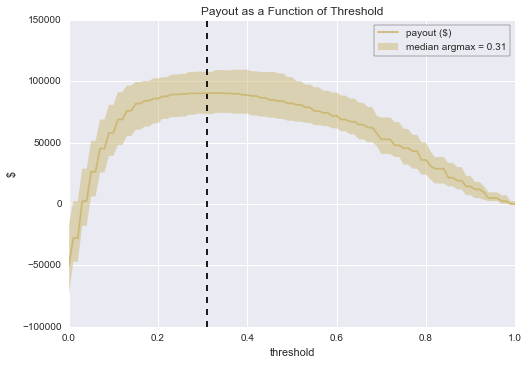

In [14]:
uniform_thresholds = np.linspace(0, 1, 101)
uniform_payout_plots = []
n = 10000  
success_payoff = 100  
case_cost = 20

for p in plot_data:  
    uniform_payout = []
    for ut in uniform_thresholds:
        index = bisect.bisect_left(p['thresholds'], ut)
        precision = p['precision'][index]
        queue_rate = p['queue_rate'][index]
        payout = n*queue_rate*(precision*100 - case_cost)
        uniform_payout.append(payout)
    uniform_payout_plots.append(uniform_payout)

quantiles = [0.1, 0.5, 0.9]
lower_payout, median_payout, upper_payout = mstats.mquantiles(uniform_payout_plots, quantiles, axis=0)

plt.plot(uniform_thresholds, median_payout, color=sns.color_palette()[4])  
plt.fill_between(uniform_thresholds, upper_payout, lower_payout, alpha=0.5, linewidth=0, color=sns.color_palette()[4])

max_ap = uniform_thresholds[np.argmax(median_payout)]  
plt.vlines([max_ap], -100000, 150000, linestyles='--')  
plt.ylim(-100000, 150000)

leg = plt.legend(('payout ($)', 'median argmax = {:.2f}'.format(max_ap)), frameon=True)  
leg.get_frame().set_edgecolor('k')  
plt.xlabel('threshold')  
plt.ylabel('$')  
plt.title("Payout as a Function of Threshold")  

In [22]:
print '{0:.0f}'.format(np.max(median_payout))

90419
